In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [285]:
df=pd.read_csv('plot_RF.csv')
df=df.iloc[:,1:]
df.head()

,BCT_Code,Ridership,MonthS,DOWS,y_pred
0,1000201,228,1,0,197.02
1,1000201,230,1,2,205.62
2,1000201,229,1,3,211.83
3,1000201,191,1,4,184.04
4,1000201,148,1,5,163.24


In [286]:
season_dict = {1: 'Winter',
               2: 'Winter',
               3: 'Spring', 
               4: 'Spring',
               5: 'Spring',
               6: 'Summer',
               7: 'Summer',
               8: 'Summer',
               9: 'Autumn',
               10: 'Autumn',
               11: 'Autumn',
               12: 'Winter'}
df['Season'] = df['MonthS'].apply(lambda x: season_dict[x])

In [287]:
dow_dict = {1: 'Weekday',
               2: 'Weekday',
               3: 'Weekday', 
               4: 'Weekday',
               5: 'Weekday',
               6: 'Weekend',
               0: 'Weekend'}
df['DOW']=df['DOWS'].apply(lambda x: dow_dict[x])

In [288]:
season=df.groupby(['Season','BCT_Code'])[['Ridership','y_pred']].sum()
season.reset_index(inplace=True)
season['difference']=season['y_pred']-season['Ridership']
dow=df.groupby(['DOW','BCT_Code'])[['Ridership','y_pred']].sum()
dow.reset_index(inplace=True)
dow['difference']=dow['y_pred']-dow['Ridership']

In [289]:
total=df.groupby(['BCT_Code'])[['Ridership','y_pred']].sum()
total.reset_index(inplace=True)
total['difference']=total['y_pred']-total['Ridership']

In [290]:
import geopandas as gpd
city=pd.read_csv('CTGeo.csv')
city.head(2)

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-74.04387761639944 40.69018767...,1.00,1,Manhattan,100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,MULTIPOLYGON (((-73.98449647076764 40.70950966...,2.01,1,Manhattan,201,1000201,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05


## Plot for Four Seasons

### Observed Trends

In [291]:
geo=pd.merge(city,season,left_on='BoroCT2020', right_on='BCT_Code',how='right')

geo['the_geom'] = gpd.GeoSeries.from_wkt(geo['the_geom'])
geo = gpd.GeoDataFrame(geo, geometry='the_geom')
geo=geo.set_crs('epsg: 4326')

In [292]:
pred_std=np.std(geo['y_pred'])
fil=[]
for i in range(len(geo)):
    diff=geo.at[i,'difference']
    if diff > (2*pred_std):
        a='Yes, over'
    elif diff < (-2*pred_std):
        a='Yes, under'
    else:
        a='No'
    fil.append(a)
geo['>2std']=fil

In [293]:
spring=geo[geo['Season'] == 'Spring']
summer=geo[geo['Season'] == 'Summer']
autumn=geo[geo['Season'] == 'Autumn']
winter=geo[geo['Season'] == 'Winter']

In [294]:
city['the_geom'] = gpd.GeoSeries.from_wkt(city['the_geom'])
city = gpd.GeoDataFrame(city, geometry='the_geom')
city=city.set_crs('epsg: 4326')

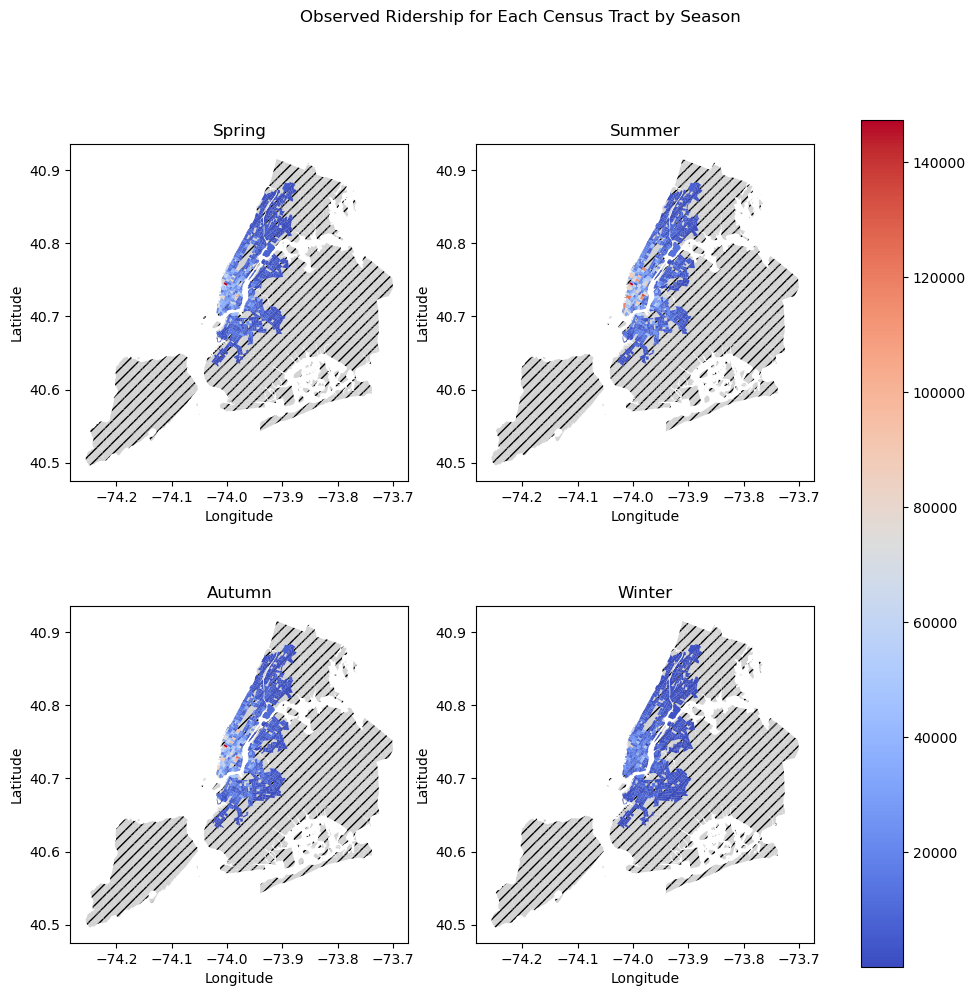

In [295]:
vmin = spring['Ridership'].min()
vmax = spring['Ridership'].max()
fig, ax = plt.subplots(2,2,figsize=(12,11))
city.plot(ax=ax[0,0], color='LightGrey',hatch='///')
city.plot(ax=ax[0,1], color='LightGrey',hatch='///')
city.plot(ax=ax[1,0], color='LightGrey',hatch='///')
city.plot(ax=ax[1,1], color='LightGrey',hatch='///')
spring.plot(ax = ax[0,0], column='Ridership', cmap = 'coolwarm',vmin=vmin,vmax=vmax)
summer.plot(ax = ax[0,1], column='Ridership', cmap = 'coolwarm',vmin=vmin,vmax=vmax)
autumn.plot(ax = ax[1,0], column='Ridership', cmap = 'coolwarm',vmin=vmin,vmax=vmax)
winter.plot(ax = ax[1,1], column='Ridership', cmap = 'coolwarm',vmin=vmin,vmax=vmax)

fig.suptitle('Observed Ridership for Each Census Tract by Season', fontsize=12)
ax[0,0].set_xlabel('Longitude', fontsize=10)
ax[0,1].set_xlabel('Longitude', fontsize=10)
ax[1,0].set_xlabel('Longitude', fontsize=10)
ax[1,1].set_xlabel('Longitude', fontsize=10)
ax[0,0].set_ylabel('Latitude', fontsize=10)
ax[0,1].set_ylabel('Latitude', fontsize=10)
ax[1,0].set_ylabel('Latitude', fontsize=10)
ax[1,1].set_ylabel('Latitude', fontsize=10)
ax[0,0].set_title('Spring')
ax[0,1].set_title('Summer')
ax[1,0].set_title('Autumn')
ax[1,1].set_title('Winter')
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap='coolwarm'),ax=ax)

### Plot the Outliers

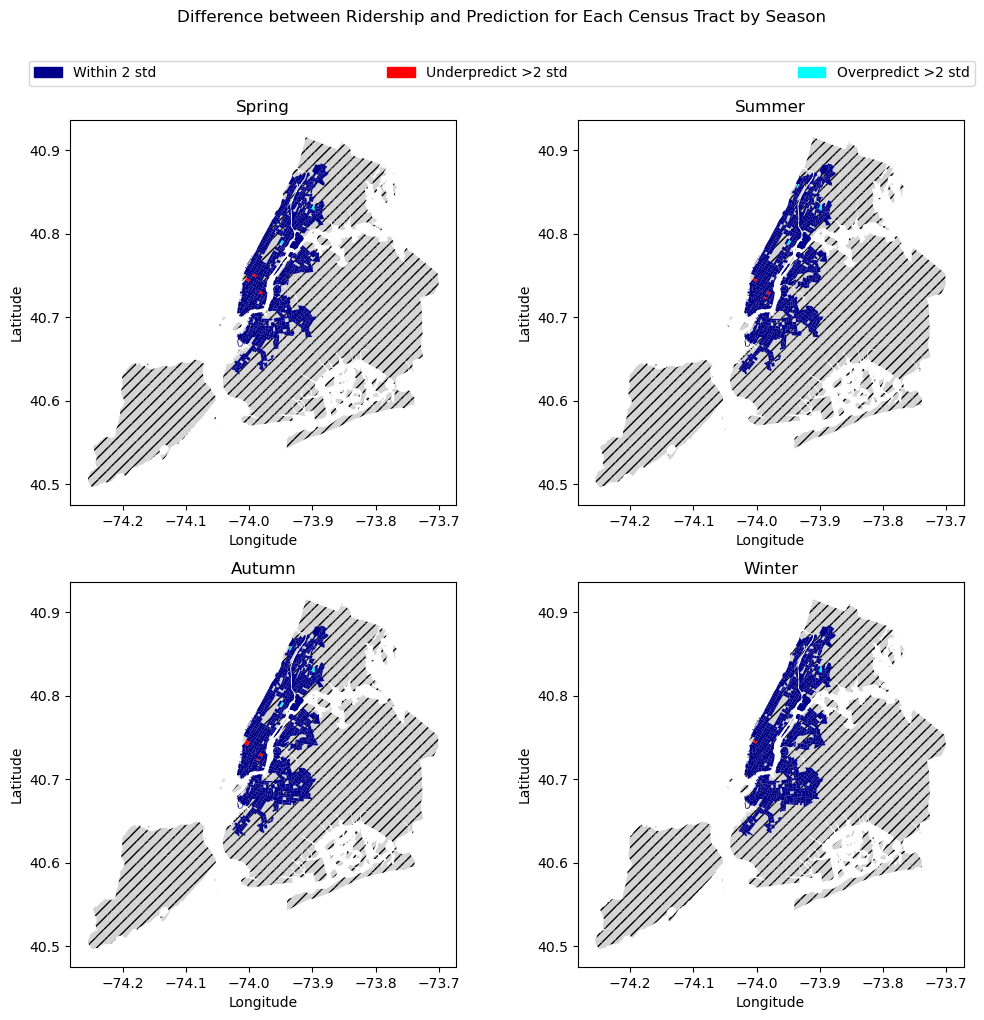

In [310]:

fig, ax = plt.subplots(2,2,figsize=(12,11))
city.plot(ax=ax[0,0], color='LightGrey',hatch='///')
city.plot(ax=ax[0,1], color='LightGrey',hatch='///')
city.plot(ax=ax[1,0], color='LightGrey',hatch='///')
city.plot(ax=ax[1,1], color='LightGrey',hatch='///')
spring[spring['>2std'] == 'No'].plot(ax = ax[0,0], color = 'darkblue',label='Within 2 std')
spring[spring['>2std'] == 'Yes, under'].plot(ax = ax[0,0], color = 'red',label='Underpredict >2 std')
spring[spring['>2std'] == 'Yes, over'].plot(ax = ax[0,0], color = 'cyan',label='Onderpredict >2 std')
summer[summer['>2std'] == 'No'].plot(ax = ax[0,1], color = 'darkblue',label='Within 2 std')
summer[summer['>2std'] == 'Yes, under'].plot(ax = ax[0,1], color = 'red',label='Underpredict >2 std')
summer[summer['>2std'] == 'Yes, over'].plot(ax = ax[0,1], color = 'cyan',label='Onderpredict >2 std')
autumn[autumn['>2std'] == 'No'].plot(ax = ax[1,0], color = 'darkblue',label='Within 2 std')
autumn[autumn['>2std'] == 'Yes, under'].plot(ax = ax[1,0], color = 'red',label='Underpredict >2 std')
autumn[autumn['>2std'] == 'Yes, over'].plot(ax = ax[1,0], color = 'cyan',label='Onderpredict >2 std')
winter[winter['>2std'] == 'No'].plot(ax = ax[1,1], color = 'darkblue',label='Within 2 std')
winter[winter['>2std'] == 'Yes, under'].plot(ax = ax[1,1], color = 'red',label='Underpredict >2 std')
winter[winter['>2std'] == 'Yes, over'].plot(ax = ax[1,1], color = 'cyan',label='Onderpredict >2 std')

fig.suptitle('Difference between Ridership and Prediction for Each Census Tract by Season', fontsize=12)
ax[0,0].set_xlabel('Longitude', fontsize=10)
ax[0,1].set_xlabel('Longitude', fontsize=10)
ax[1,0].set_xlabel('Longitude', fontsize=10)
ax[1,1].set_xlabel('Longitude', fontsize=10)
ax[0,0].set_ylabel('Latitude', fontsize=10)
ax[0,1].set_ylabel('Latitude', fontsize=10)
ax[1,0].set_ylabel('Latitude', fontsize=10)
ax[1,1].set_ylabel('Latitude', fontsize=10)
ax[0,0].set_title('Spring')
ax[0,1].set_title('Summer')
ax[1,0].set_title('Autumn')
ax[1,1].set_title('Winter')

p1 = mpatches.Patch(color='darkblue', label='Within 2 std')
p2 = mpatches.Patch(color='red', label='Underpredict >2 std')
p3 = mpatches.Patch(color='cyan', label='Overpredict >2 std')
fig.legend(handles=[p1,p2,p3],loc='upper center', bbox_to_anchor=(0.1, .83, .8, .11),mode="expand",ncol=3)

## Plot DOW 

### Plot the Trends

In [298]:
geo=pd.merge(city,dow,left_on='BoroCT2020', right_on='BCT_Code',how='right')

In [299]:
pred_std=np.std(geo['y_pred'])
fil=[]
for i in range(len(geo)):
    diff=geo.at[i,'difference']
    if diff > (2*pred_std):
        a='Yes, over'
    elif diff < (-2*pred_std):
        a='Yes, under'
    else:
        a='No'
    fil.append(a)
geo['>2std']=fil

In [300]:
weekday=geo[geo['DOW'] == 'Weekday']
weekend=geo[geo['DOW'] == 'Weekend']

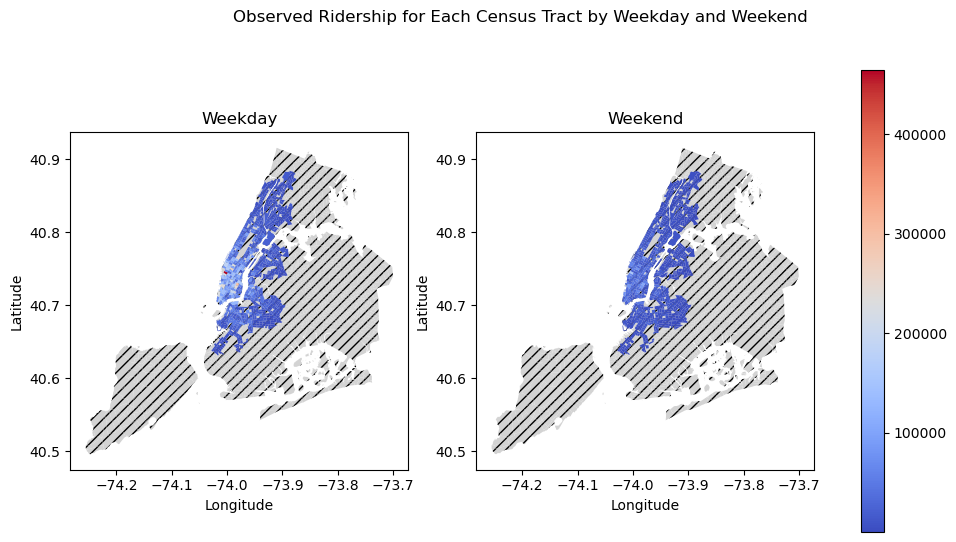

In [301]:
vmin = weekday['Ridership'].min()
vmax = weekday['Ridership'].max()

fig, ax = plt.subplots(1,2,figsize=(12,6))
city.plot(ax=ax[0], color='LightGrey',hatch='///')
city.plot(ax=ax[1], color='LightGrey',hatch='///')

weekday.plot(ax = ax[0], column='Ridership', cmap = 'coolwarm',vmin=vmin,vmax=vmax)
weekend.plot(ax = ax[1], column='Ridership', cmap = 'coolwarm',vmin=vmin,vmax=vmax)

fig.suptitle('Observed Ridership for Each Census Tract by Weekday and Weekend', fontsize=12)
ax[0].set_xlabel('Longitude', fontsize=10)
ax[1].set_xlabel('Longitude', fontsize=10)
ax[0].set_ylabel('Latitude', fontsize=10)
ax[1].set_ylabel('Latitude', fontsize=10)
ax[0].set_title('Weekday')
ax[1].set_title('Weekend')
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap='coolwarm'),ax=ax)

### Plot the Outliers

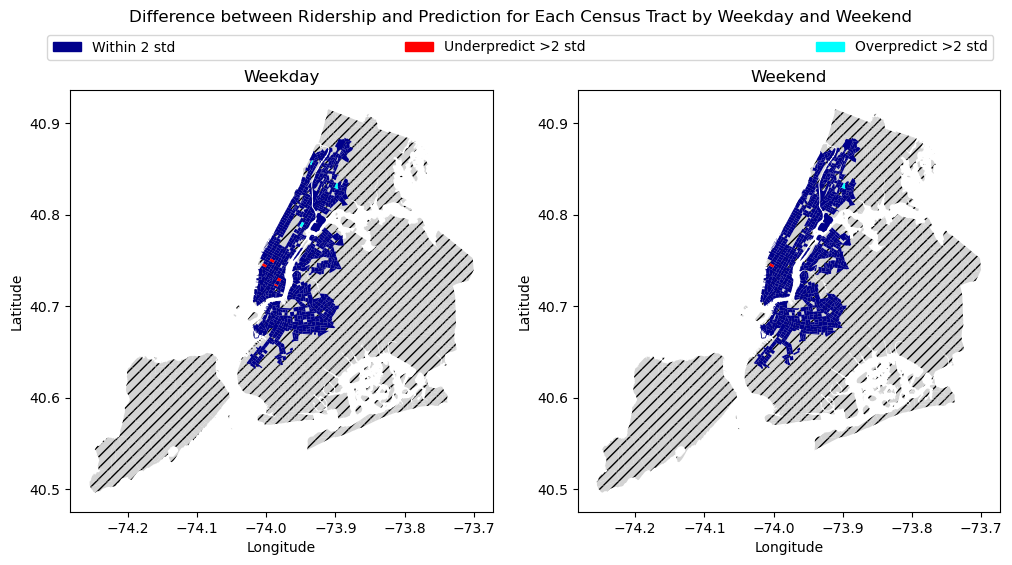

In [308]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
city.plot(ax=ax[0], color='LightGrey',hatch='///')
city.plot(ax=ax[1], color='LightGrey',hatch='///')

weekday[weekday['>2std'] == 'No'].plot(ax = ax[0], color = 'darkblue',label='Within 2 std')
weekday[weekday['>2std'] == 'Yes, under'].plot(ax = ax[0], color = 'red',label='Underpredict >2 std')
weekday[weekday['>2std'] == 'Yes, over'].plot(ax = ax[0], color = 'cyan',label='Onderpredict >2 std')

weekend[weekend['>2std'] == 'No'].plot(ax = ax[1], color = 'darkblue',label='Within 2 std')
weekend[weekend['>2std'] == 'Yes, under'].plot(ax = ax[1], color = 'red',label='Underpredict >2 std')
weekend[weekend['>2std'] == 'Yes, over'].plot(ax = ax[1], color = 'cyan',label='Onderpredict >2 std')


fig.suptitle('Difference between Ridership and Prediction for Each Census Tract by Weekday and Weekend', fontsize=12)
ax[0].set_xlabel('Longitude', fontsize=10)
ax[1].set_xlabel('Longitude', fontsize=10)
ax[0].set_ylabel('Latitude', fontsize=10)
ax[1].set_ylabel('Latitude', fontsize=10)
ax[0].set_title('Weekday')
ax[1].set_title('Weekend')

p1 = mpatches.Patch(color='darkblue', label='Within 2 std')
p2 = mpatches.Patch(color='red', label='Underpredict >2 std')
p3 = mpatches.Patch(color='cyan', label='Overpredict >2 std')
fig.legend(handles=[p1,p2,p3],loc='upper center', bbox_to_anchor=(0.1, .83, .8, .12),mode="expand",ncol=3)

## Total Outlier

In [303]:
totalgeo=pd.merge(city,total,left_on='BoroCT2020', right_on='BCT_Code',how='right')
pred_std=np.std(totalgeo['y_pred'])
fil=[]
for i in range(len(totalgeo)):
    diff=totalgeo.at[i,'difference']
    if diff > (2*pred_std):
        a='Yes, over'
    elif diff < (-2*pred_std):
        a='Yes, under'
    else:
        a='No'
    fil.append(a)
totalgeo['>2std']=fil

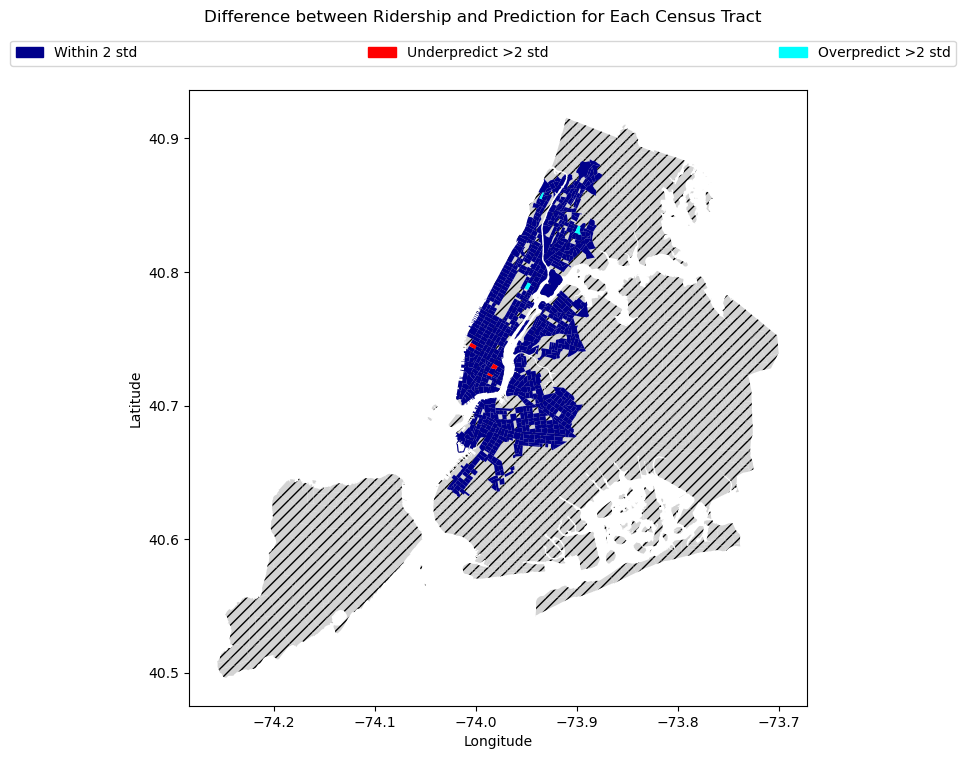

In [311]:
fig, ax = plt.subplots(figsize=(12,8))
city.plot(ax=ax, color='LightGrey',hatch='///')

totalgeo[totalgeo['>2std'] == 'No'].plot(ax = ax, color = 'darkblue',label='Within 2 std')
totalgeo[totalgeo['>2std'] == 'Yes, under'].plot(ax = ax, color = 'red',label='Underpredict >2 std')
totalgeo[totalgeo['>2std'] == 'Yes, over'].plot(ax = ax, color = 'cyan',label='Onderpredict >2 std')

fig.suptitle('Difference between Ridership and Prediction for Each Census Tract', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

p1 = mpatches.Patch(color='darkblue', label='Within 2 std')
p2 = mpatches.Patch(color='red', label='Underpredict >2 std')
p3 = mpatches.Patch(color='cyan', label='Overpredict >2 std')
fig.legend(handles=[p1,p2,p3],loc='upper center', bbox_to_anchor=(0.1, .83, .8, .12),mode="expand",ncol=3)